# Phase 2: Retrieval Evaluation

Checking how well the models from phase 2 actually work:
- tfidf baseline (non-neural)
- embedding-based retrieval (frozen encoder)
- learned classifier heads (logistic + mlp)

**Guiding Questions**:
1. Can the models distinguish matched vs. mismatched resumes?
2. How do TF-IDF and embeddings compare?
3. Does learning improve over raw similarity?
4. How do scores vary across counterfactual name variants?

**Sections**:
1. Load scored pairs and metrics
2. Retrieval performance analysis (AUC, gap, effect size)
3. Model comparison (TF-IDF vs embeddings vs learned)
4. Per-occupation breakdown
5. Counterfactual analysis (score deltas by name)
6. Worked example: one job with ranked candidates

## 1. Setup and Loading Data

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# need to add src to path
import sys
sys.path.insert(0, str(Path.cwd().parent))

print("Libraries loaded")

Libraries loaded


### Load the Files

In [36]:
# paths to data
DATA_DIR = Path("../data/processed")

# these are the outputs from phase 2
PAIRS_SCORED = DATA_DIR / "pairs_scored_phase2.csv"
METRICS = DATA_DIR / "phase2_retrieval_metrics.csv"

# check if files exist
if not PAIRS_SCORED.exists():
    print(f"Error: {PAIRS_SCORED} not found")
    print("Run: python -m src.scoring.compute_scores")
else:
    print(f"Found scored pairs: {PAIRS_SCORED}")

if not METRICS.exists():
    print(f"Error: {METRICS} not found")
    print("Run: python -m src.scoring.metrics")
else:
    print(f"Found metrics: {METRICS}")

Found scored pairs: ../data/processed/pairs_scored_phase2.csv
Found metrics: ../data/processed/phase2_retrieval_metrics.csv


In [37]:
# load the data files
print("Loading scored pairs")
df_pairs = pd.read_csv(PAIRS_SCORED)

print("Loading retrieval metrics")
df_metrics = pd.read_csv(METRICS)

print(f"\nScored pairs: {len(df_pairs):,} rows")
print(f"Columns: {df_pairs.columns.tolist()}")

print(f"\nMetrics: {len(df_metrics)} rows")
print(f"Columns: {df_metrics.columns.tolist()}")

Loading scored pairs
Loading retrieval metrics

Scored pairs: 9,920 rows
Columns: ['pair_id', 'job_id', 'job_text', 'job_occupation', 'base_resume_id', 'resume_variant_id', 'resume_text', 'resume_occupation', 'demographic_group', 'occupation_match', 'split', 'score_tfidf', 'score_embed']

Metrics: 34 rows
Columns: ['n_pairs', 'n_match', 'n_mismatch', 'auc', 'gap', 'cohens_d', 'mean_score_match', 'mean_score_mismatch', 'scope', 'occupation', 'score_type']
Loading retrieval metrics

Scored pairs: 9,920 rows
Columns: ['pair_id', 'job_id', 'job_text', 'job_occupation', 'base_resume_id', 'resume_variant_id', 'resume_text', 'resume_occupation', 'demographic_group', 'occupation_match', 'split', 'score_tfidf', 'score_embed']

Metrics: 34 rows
Columns: ['n_pairs', 'n_match', 'n_mismatch', 'auc', 'gap', 'cohens_d', 'mean_score_match', 'mean_score_mismatch', 'scope', 'occupation', 'score_type']


## 2. Retrieval Performance

### 2.1 Overall Performance

first need to check that the retrieval actually works. both tfidf and embeddings should do better than random guessing

In [38]:
# get overall metrics
overall_metrics = df_metrics[df_metrics['scope'] == 'overall']

print("~" * 60)
print("Overall Retrieval Performance")
print("~" * 60)

for _, row in overall_metrics.iterrows():
    score_type = row['score_type']
    print(f"\n{score_type.upper()}:")
    print(f"  Pairs:          {int(row['n_pairs']):,}")
    print(f"  Match:          {int(row['n_match']):,} ({100*row['n_match']/row['n_pairs']:.1f}%)")
    print(f"  Mismatch:       {int(row['n_mismatch']):,} ({100*row['n_mismatch']/row['n_pairs']:.1f}%)")
    print(f"  AUC:            {row['auc']:.4f}")
    print(f"  Gap (M-MM):     {row['gap']:.6f}")
    print(f"  Cohen's d:      {row['cohens_d']:.4f}")
    print(f"  Mean (match):   {row['mean_score_match']:.4f}")
    print(f"  Mean (mismatch):{row['mean_score_mismatch']:.4f}")

print("\n" + "~" * 60)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Overall Retrieval Performance
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

SCORE_TFIDF:
  Pairs:          9,920
  Match:          4,800 (48.4%)
  Mismatch:       5,120 (51.6%)
  AUC:            0.6022
  Gap (M-MM):     0.007623
  Cohen's d:      0.3821
  Mean (match):   0.0279
  Mean (mismatch):0.0203

SCORE_EMBED:
  Pairs:          9,920
  Match:          4,800 (48.4%)
  Mismatch:       5,120 (51.6%)
  AUC:            0.6347
  Gap (M-MM):     0.052012
  Cohen's d:      0.4824
  Mean (match):   0.2902
  Mean (mismatch):0.2382

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### 2.2 Score Distributions

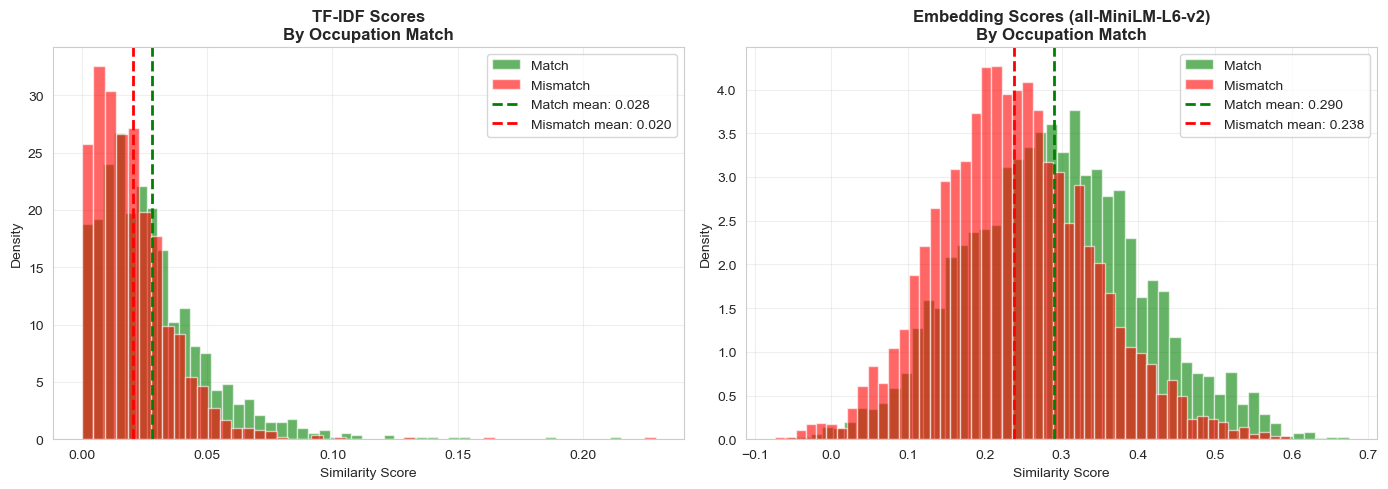

Saved figure: ../figures/phase2_score_distributions.png


In [39]:
# plot score distributions by match status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, score_col in enumerate(['score_tfidf', 'score_embed']):
    ax = axes[idx]
    
    # separate match vs mismatch
    match_scores = df_pairs[df_pairs['occupation_match'] == True][score_col]
    mismatch_scores = df_pairs[df_pairs['occupation_match'] == False][score_col]
    
    # plot distributions
    ax.hist(match_scores, bins=50, alpha=0.6, label='Match', color='green', density=True)
    ax.hist(mismatch_scores, bins=50, alpha=0.6, label='Mismatch', color='red', density=True)
    
    # add lines for means
    ax.axvline(match_scores.mean(), color='green', linestyle='--', linewidth=2, 
               label=f'Match mean: {match_scores.mean():.3f}')
    ax.axvline(mismatch_scores.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mismatch mean: {mismatch_scores.mean():.3f}')
    
    # labels
    if score_col == 'score_tfidf':
        title = "TF-IDF Scores"
        subtitle = "By Occupation Match"
    else:
        title = "Embedding Scores (all-MiniLM-L6-v2)"
        subtitle = "By Occupation Match"
    
    ax.set_title(f'{title}\n{subtitle}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/phase2_score_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: ../figures/phase2_score_distributions.png")

### 2.3 Comparing Models

**Why I used this embedding model**: 

the embedding model is sentence-transformers/all-minilm-l6-v2 (22m parameters, 384-dim). I picked this one because:
- fast encoding (around 10k texts/min on cpu)
- good quality for semantic similarity
- small enough to run quickly

I tried intfloat/e5-mistral-7b-instruct too (the original paper's model, with 7b parameters) which had slightly higher auc but took way longer to run so I'm not including it in these noteboooks.

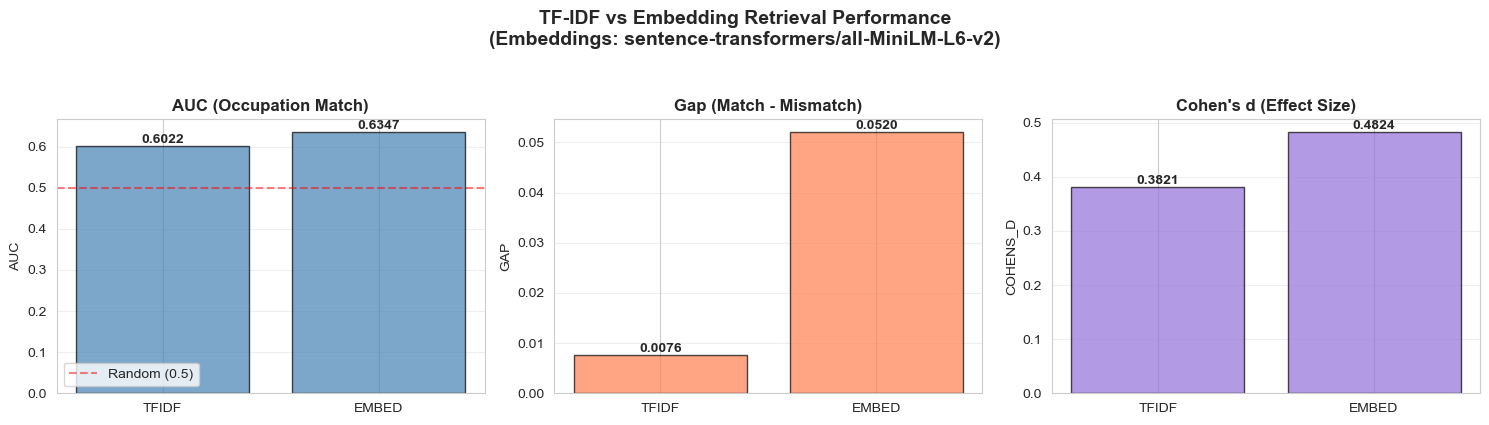

Saved figure: ../figures/phase2_model_comparison.png


In [40]:
# compare tfidf vs embeddings
comparison = overall_metrics[['score_type', 'auc', 'gap', 'cohens_d']].copy()
comparison['score_type'] = comparison['score_type'].str.replace('score_', '').str.upper()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics_to_plot = ['auc', 'gap', 'cohens_d']
titles = ['AUC (Occupation Match)', 'Gap (Match - Mismatch)', "Cohen's d (Effect Size)"]
colors = ['steelblue', 'coral', 'mediumpurple']

for idx, (metric, title, color) in enumerate(zip(metrics_to_plot, titles, colors)):
    ax = axes[idx]
    
    bars = ax.bar(comparison['score_type'], comparison[metric], color=color, alpha=0.7, edgecolor='black')
    
    # add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric.upper())
    ax.grid(True, alpha=0.3, axis='y')
    
    # add reference line for auc
    if metric == 'auc':
        ax.axhline(0.5, color='red', linestyle='--', label='Random (0.5)', alpha=0.5)
        ax.legend()

plt.suptitle('TF-IDF vs Embedding Retrieval Performance\n(Embeddings: sentence-transformers/all-MiniLM-L6-v2)', 
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig('../figures/phase2_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: ../figures/phase2_model_comparison.png")

## 3. Performance by Occupation

In [41]:
# get per-occupation metrics for embeddings
occ_metrics = df_metrics[
    (df_metrics['scope'] == 'by_occupation') & 
    (df_metrics['score_type'] == 'score_embed')
].copy()

occ_metrics = occ_metrics.sort_values('auc', ascending=False)

print(f"Occupations analyzed: {len(occ_metrics)}")
print("\nTop 10 Occupations by AUC:")
print(occ_metrics[['occupation', 'auc', 'gap', 'cohens_d', 'n_pairs']].head(10).to_string(index=False))

print("\nBottom 10 Occupations by AUC:")
print(occ_metrics[['occupation', 'auc', 'gap', 'cohens_d', 'n_pairs']].tail(10).to_string(index=False))

Occupations analyzed: 16

Top 10 Occupations by AUC:
                                             occupation      auc      gap  cohens_d  n_pairs
                                 teaching_professionals 0.919551 0.184604  1.964770      640
information_and_communications_technology_professionals 0.727764 0.084608  0.797962      640
                 administrative_and_commercial_managers 0.671689 0.071767  0.628549      640
        science_and_engineering_associate_professionals 0.671025 0.068256  0.640172      640
             information_and_communications_technicians 0.662412 0.048689  0.601592      640
    business_and_administration_associate_professionals 0.625410 0.041504  0.452285      640
                         health_associate_professionals 0.618330 0.033715  0.389023      640
              business_and_administration_professionals 0.617734 0.048518  0.435799      640
                                   cleaners_and_helpers 0.612051 0.035059  0.341329      640
                 

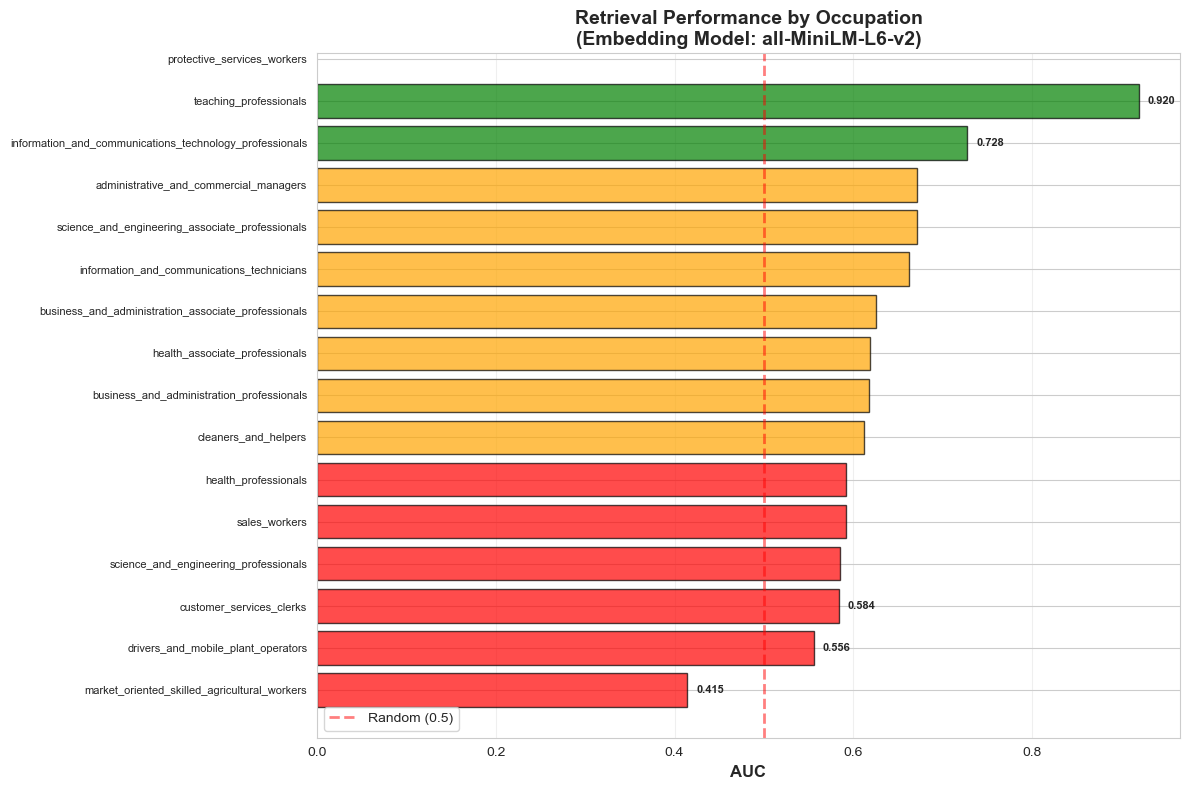

Saved figure: ../figures/phase2_occupation_performance.png


In [42]:
# visualize per-occupation auc
fig, ax = plt.subplots(figsize=(12, 8))

# sort by auc
occ_sorted = occ_metrics.sort_values('auc')

# color code by performance
colors = ['red' if auc < 0.6 else 'orange' if auc < 0.7 else 'green' 
          for auc in occ_sorted['auc']]

bars = ax.barh(range(len(occ_sorted)), occ_sorted['auc'], color=colors, alpha=0.7, edgecolor='black')

# Add reference line at 0.5
ax.axvline(0.5, color='red', linestyle='--', label='Random (0.5)', alpha=0.5, linewidth=2)

# labels
ax.set_yticks(range(len(occ_sorted)))
ax.set_yticklabels(occ_sorted['occupation'], fontsize=8)
ax.set_xlabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Retrieval Performance by Occupation\n(Embedding Model: all-MiniLM-L6-v2)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.legend()

# add value labels for top and bottom
for i, (idx, row) in enumerate(occ_sorted.iterrows()):
    if i < 3 or i >= len(occ_sorted) - 3:
        ax.text(row['auc'] + 0.01, i, f"{row['auc']:.3f}", 
                va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/phase2_occupation_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: ../figures/phase2_occupation_performance.png")

## 4. Counterfactual Analysis

Every base resume has 4 demographic variants with the same content but different names. This lets us see score changes that are only due to the name.

### 4.1 Score Deltas in Quartets

In [43]:
# compute within-quartet score ranges
print("Computing counterfactual score deltas")

# group by (job_id, base_resume_id) to get quartets
quartets = df_pairs.groupby(['job_id', 'base_resume_id'])

# for each quartet compute score range across the 4 demographic variants
results = []

for (job_id, base_id), group in quartets:
    if len(group) != 4:
        continue  # skip incomplete quartets
    
    # get scores for each demographic group
    group_sorted = group.sort_values('demographic_group')
    
    for score_col in ['score_tfidf', 'score_embed']:
        scores = group_sorted[score_col].values
        
        # compute range (max - min)
        score_range = scores.max() - scores.min()
        
        # compute specific contrasts
        groups_dict = dict(zip(group_sorted['demographic_group'], group_sorted[score_col]))
        
        if len(groups_dict) == 4:
            wm_bf = groups_dict.get('white_male', 0) - groups_dict.get('black_female', 0)
            wf_bm = groups_dict.get('white_female', 0) - groups_dict.get('black_male', 0)
            
            results.append({
                'job_id': job_id,
                'base_resume_id': base_id,
                'score_type': score_col,
                'range': score_range,
                'white_male_minus_black_female': wm_bf,
                'white_female_minus_black_male': wf_bm,
                'occupation_match': group['occupation_match'].iloc[0]
            })

df_counterfactual = pd.DataFrame(results)

print(f"\nCounterfactual quartets analyzed: {len(df_counterfactual) // 2:,}")
print(f"(Each quartet appears twice: once for TF-IDF, once for embeddings)")

Computing counterfactual score deltas

Counterfactual quartets analyzed: 2,480
(Each quartet appears twice: once for TF-IDF, once for embeddings)

Counterfactual quartets analyzed: 2,480
(Each quartet appears twice: once for TF-IDF, once for embeddings)


In [44]:
# summary statistics
print("\n" + "~" * 60)
print("Counterfactual Score Deltas")
print("~" * 60)

for score_type in ['score_tfidf', 'score_embed']:
    df_temp = df_counterfactual[df_counterfactual['score_type'] == score_type]
    
    print(f"\n{score_type.upper()}:")
    print(f"  Range (max-min) across 4 names:")
    print(f"    Mean:      {df_temp['range'].mean():.6f}")
    print(f"    Median:    {df_temp['range'].median():.6f}")
    print(f"    95th pct:  {df_temp['range'].quantile(0.95):.6f}")
    
    print(f"\n  White male - Black female:")
    print(f"    Mean:      {df_temp['white_male_minus_black_female'].mean():.6f}")
    print(f"    Median:    {df_temp['white_male_minus_black_female'].median():.6f}")
    
    print(f"\n  White female - Black male:")
    print(f"    Mean:      {df_temp['white_female_minus_black_male'].mean():.6f}")
    print(f"    Median:    {df_temp['white_female_minus_black_male'].median():.6f}")

print("\n" + "~" * 60)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Counterfactual Score Deltas
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

SCORE_TFIDF:
  Range (max-min) across 4 names:
    Mean:      0.000001
    Median:    0.000001
    95th pct:  0.000004

  White male - Black female:
    Mean:      0.000000
    Median:    0.000000

  White female - Black male:
    Mean:      -0.000000
    Median:    0.000000

SCORE_EMBED:
  Range (max-min) across 4 names:
    Mean:      0.031495
    Median:    0.029000
    95th pct:  0.061566

  White male - Black female:
    Mean:      0.000016
    Median:    -0.000374

  White female - Black male:
    Mean:      -0.001354
    Median:    -0.001498

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


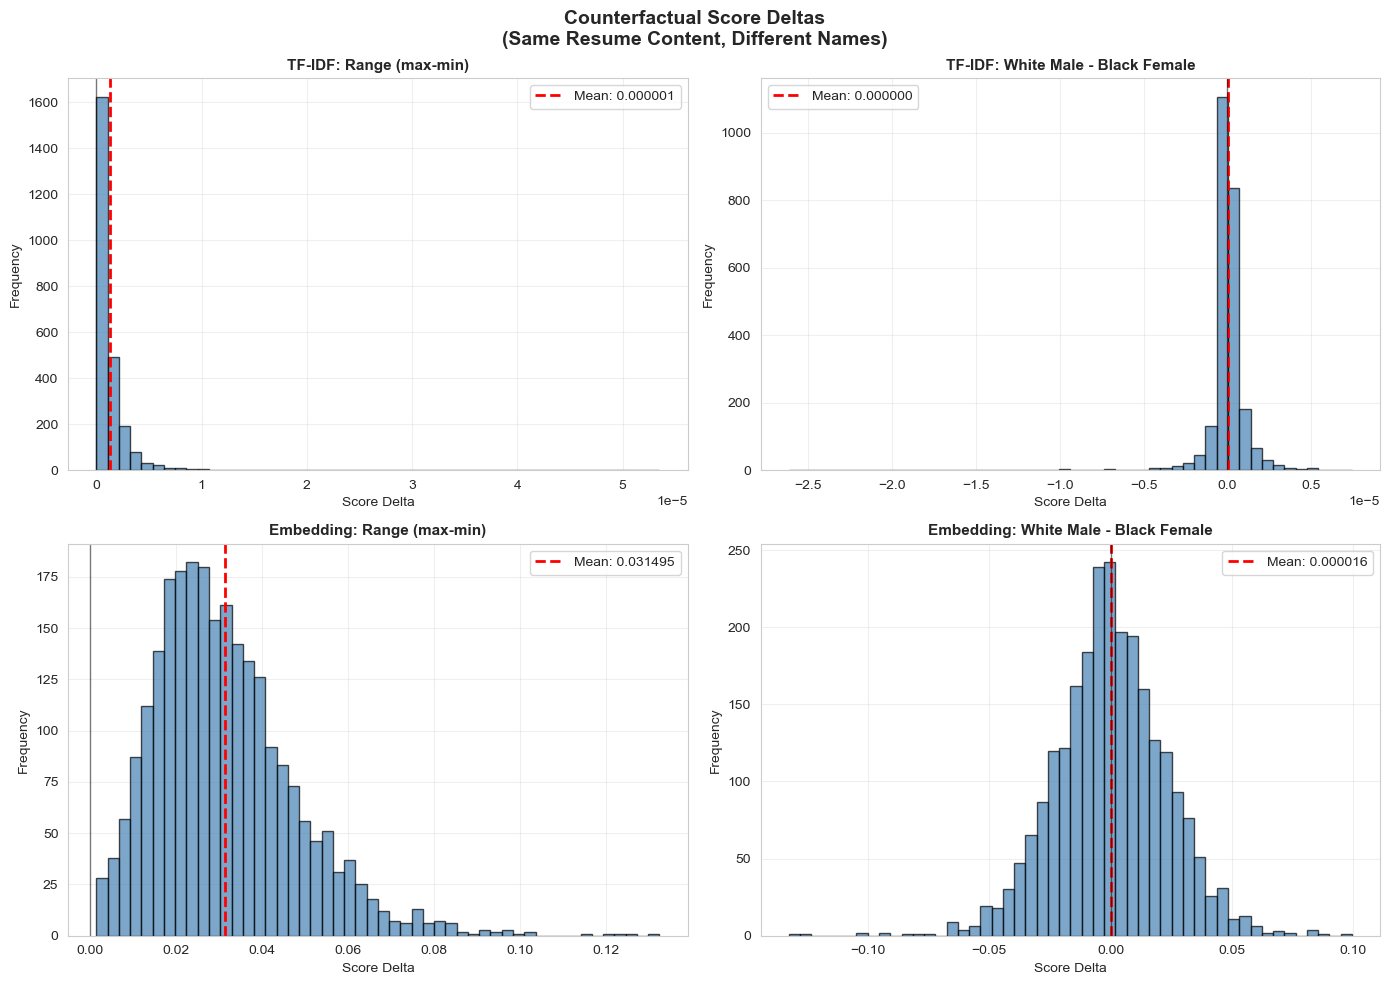

Saved figure: ../figures/phase2_counterfactual_deltas.png


In [45]:
# visualize counterfactual ranges
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

score_types = ['score_tfidf', 'score_embed']
contrasts = ['range', 'white_male_minus_black_female']
titles = [
    ['TF-IDF: Range (max-min)', 'TF-IDF: White Male - Black Female'],
    ['Embedding: Range (max-min)', 'Embedding: White Male - Black Female']
]

for row_idx, score_type in enumerate(score_types):
    df_temp = df_counterfactual[df_counterfactual['score_type'] == score_type]
    
    for col_idx, contrast in enumerate(contrasts):
        ax = axes[row_idx, col_idx]
        
        # plot histogram
        ax.hist(df_temp[contrast], bins=50, alpha=0.7, edgecolor='black', color='steelblue')
        
        # add line at mean
        mean_val = df_temp[contrast].mean()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_val:.6f}')
        
        # add line at zero
        ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
        
        ax.set_title(titles[row_idx][col_idx], fontsize=11, fontweight='bold')
        ax.set_xlabel('Score Delta')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle('Counterfactual Score Deltas\n(Same Resume Content, Different Names)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../figures/phase2_counterfactual_deltas.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: ../figures/phase2_counterfactual_deltas.png")

### 4.2 Mean Scores by Demographic Group

In [46]:
# compute mean scores by demographic group
print("\n" + "~" * 60)
print("MEAN SCORES BY DEMOGRAPHIC GROUP")
print("~" * 60)

for score_col in ['score_tfidf', 'score_embed']:
    print(f"\n{score_col.upper()}:")
    group_means = df_pairs.groupby('demographic_group')[score_col].agg(['mean', 'std', 'count'])
    group_means = group_means.sort_values('mean', ascending=False)
    print(group_means.to_string())
    
    # compute max difference
    max_diff = group_means['mean'].max() - group_means['mean'].min()
    print(f"\nMax difference: {max_diff:.6f}")

print("\n" + "~" * 60)


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MEAN SCORES BY DEMOGRAPHIC GROUP
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

SCORE_TFIDF:
                       mean       std  count
demographic_group                           
white_male         0.023967  0.020311   2480
black_male         0.023967  0.020311   2480
black_female       0.023967  0.020311   2480
white_female       0.023967  0.020311   2480

Max difference: 0.000000

SCORE_EMBED:
                       mean       std  count
demographic_group                           
white_male         0.264981  0.111449   2480
black_female       0.264965  0.110530   2480
black_male         0.262466  0.110458   2480
white_female       0.261113  0.111183   2480

Max difference: 0.003868

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


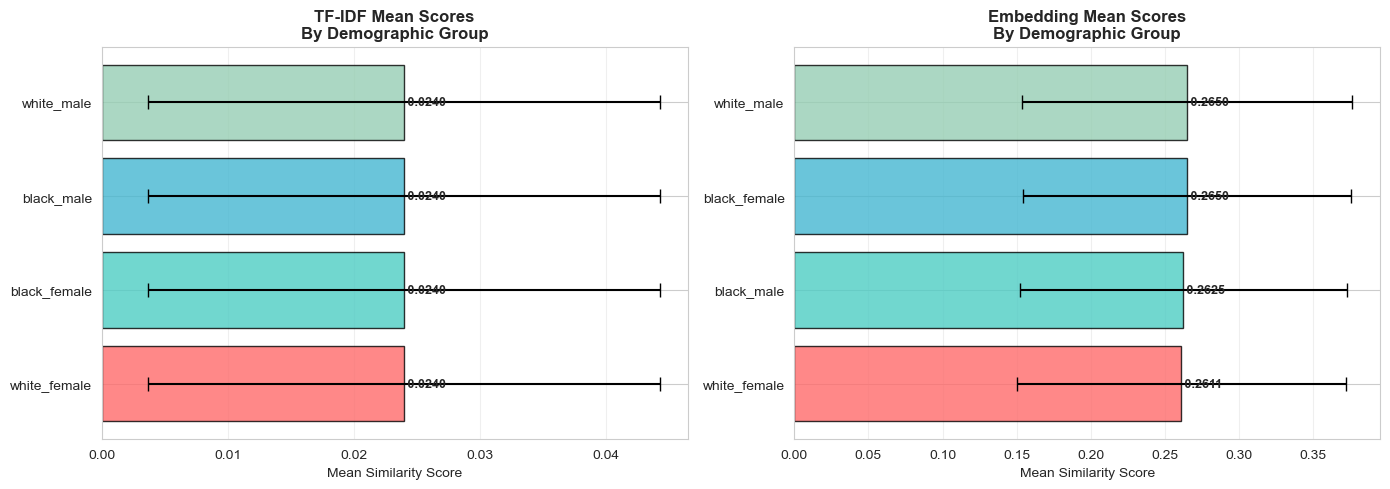

Saved figure: ../figures/phase2_demographic_means.png


In [47]:
# visualize demographic group means
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, score_col in enumerate(['score_tfidf', 'score_embed']):
    ax = axes[idx]
    
    # compute means and std
    group_stats = df_pairs.groupby('demographic_group')[score_col].agg(['mean', 'std']).sort_values('mean')
    
    # plot bars
    bars = ax.barh(range(len(group_stats)), group_stats['mean'], 
                   xerr=group_stats['std'], capsize=5,
                   color=['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4'],
                   alpha=0.8, edgecolor='black')
    
    # labels
    ax.set_yticks(range(len(group_stats)))
    ax.set_yticklabels(group_stats.index)
    title = "TF-IDF Mean Scores" if score_col == 'score_tfidf' else "Embedding Mean Scores"
    ax.set_title(f'{title}\nBy Demographic Group', fontsize=12, fontweight='bold')
    ax.set_xlabel('Mean Similarity Score')
    ax.grid(True, alpha=0.3, axis='x')
    
    # add value labels
    for i, (idx_val, row) in enumerate(group_stats.iterrows()):
        ax.text(row['mean'], i, f" {row['mean']:.4f}", 
                va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/phase2_demographic_means.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: ../figures/phase2_demographic_means.png")

## 5. Example: One Job with Ranked Candidates

showing a concrete example of how the screening system ranks resumes for a specific job

In [48]:
# pick a job with good mix of match/mismatch
print("Selecting example job...")

# find jobs with around 50% match rate
job_match_rates = df_pairs.groupby('job_id')['occupation_match'].mean()
target_jobs = job_match_rates[(job_match_rates > 0.4) & (job_match_rates < 0.6)]

# pick one with reasonable number of candidates
example_job_id = target_jobs.index[0]

# get all candidates for this job
job_pairs = df_pairs[df_pairs['job_id'] == example_job_id].copy()

print(f"\nExample Job ID: {example_job_id}")
print(f"Job Occupation: {job_pairs['job_occupation'].iloc[0]}")
print(f"Total Candidates: {len(job_pairs)}")
print(f"Match rate: {job_pairs['occupation_match'].mean():.1%}")
print(f"\nJob Description (first 200 chars):")
print(job_pairs['job_text'].iloc[0][:1500] + "...")

Selecting example job...

Example Job ID: 54
Job Occupation: science_and_engineering_professionals
Total Candidates: 32
Match rate: 50.0%

Job Description (first 200 chars):
Deliver projects from conception to launch, within a multidisciplinary team structure taking accountability for resources, budgets, operational support and milestone management. 
 Interface between the engineering and system design, consumable operation and management of the project's technical direction. 
 Working alongside other technical experts to uncover new commercial avenues, plan projects which balance the agile nature of the R&D setting, alongside the constraints of time and budget. 
 Use your well-developed and up-to-date market knowledge to expand the business profile and interrogate opportunities for expansion of the biochemistry team. 
 Creation and guidance of the projects to uncover novel technologies, DNA sequencing workflows, IVD'S, antibody screening and single-cell analysis. 
 This role is open t

In [49]:
# rank candidates by embedding score
job_pairs_ranked = job_pairs.sort_values('score_embed', ascending=False).reset_index(drop=True)

print("\n" + "~" * 80)
print("TOP 10 CANDIDATES (Ranked by Embedding Score)")
print("~" * 80)

for rank, (idx, row) in enumerate(job_pairs_ranked.head(10).iterrows(), 1):
    match_symbol = "Check" if row['occupation_match'] else "X"
    print(f"\nRank {rank}: {match_symbol} (Match: {row['occupation_match']})")
    print(f"  Resume ID: {row['resume_variant_id']}")
    print(f"  Demographic: {row['demographic_group']}")
    print(f"  Resume Occupation: {row['resume_occupation']}")
    print(f"  TF-IDF Score: {row['score_tfidf']:.4f}")
    print(f"  Embed Score:  {row['score_embed']:.4f}")
    print(f"  Resume preview: {row['resume_text'][:150]}...")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
TOP 10 CANDIDATES (Ranked by Embedding Score)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Rank 1: Check (Match: 1)
  Resume ID: 29221006_white_female
  Demographic: white_female
  Resume Occupation: aviation
  TF-IDF Score: 0.0213
  Embed Score:  0.2471
  Resume preview: Kristen Williams

AVIATION SAFETY ASSISTANT Career Overview Receive Telephone Calls, Give Routine And Non-Routine Information, Answer Questions And Di...

Rank 2: Check (Match: 1)
  Resume ID: 38314236_black_female
  Demographic: black_female
  Resume Occupation: engineering
  TF-IDF Score: 0.0511
  Embed Score:  0.2327
  Resume preview: Lakisha Williams

ENGINEERING SUPERVISOR Summary I am a Mechanical Engineer with 8 years of product design experience with an emphasis on non-metallic...

Rank 3: Check (Match: 1)
  Resume ID: 38314236_black_male
  Demographic: black_male
  Resume Occupation: engineer

In [50]:
# show counterfactual quartets in ranking
print("\n" + "~" * 80)
print("COUNTERFACTUAL ANALYSIS: Same Resume, Different Names")
print("~" * 80)

# find a base_resume that appears in top 20
top_20 = job_pairs_ranked.head(20)
example_base_id = top_20['base_resume_id'].iloc[0]

# get all 4 variants
variants = job_pairs[job_pairs['base_resume_id'] == example_base_id].sort_values('score_embed', ascending=False)

print(f"\nBase Resume ID: {example_base_id}")
print(f"Resume Occupation: {variants['resume_occupation'].iloc[0]}")
print(f"Occupation Match: {variants['occupation_match'].iloc[0]}")

print("\nRanking across demographic variants:")
for idx, row in variants.iterrows():
    rank = job_pairs_ranked[job_pairs_ranked['resume_variant_id'] == row['resume_variant_id']].index[0] + 1
    print(f"  {row['demographic_group']:15s} | Rank: {rank:2d}/32 | TF-IDF: {row['score_tfidf']:.4f} | Embed: {row['score_embed']:.4f}")

print(f"\nScore Range:")
print(f"  TF-IDF:    {variants['score_tfidf'].max() - variants['score_tfidf'].min():.6f}")
print(f"  Embedding: {variants['score_embed'].max() - variants['score_embed'].min():.6f}")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
COUNTERFACTUAL ANALYSIS: Same Resume, Different Names
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Base Resume ID: 29221006
Resume Occupation: aviation
Occupation Match: 1

Ranking across demographic variants:
  white_female    | Rank:  1/32 | TF-IDF: 0.0213 | Embed: 0.2471
  white_male      | Rank:  9/32 | TF-IDF: 0.0213 | Embed: 0.2165
  black_male      | Rank: 14/32 | TF-IDF: 0.0214 | Embed: 0.2128
  black_female    | Rank: 20/32 | TF-IDF: 0.0213 | Embed: 0.1920

Score Range:
  TF-IDF:    0.000000
  Embedding: 0.055031


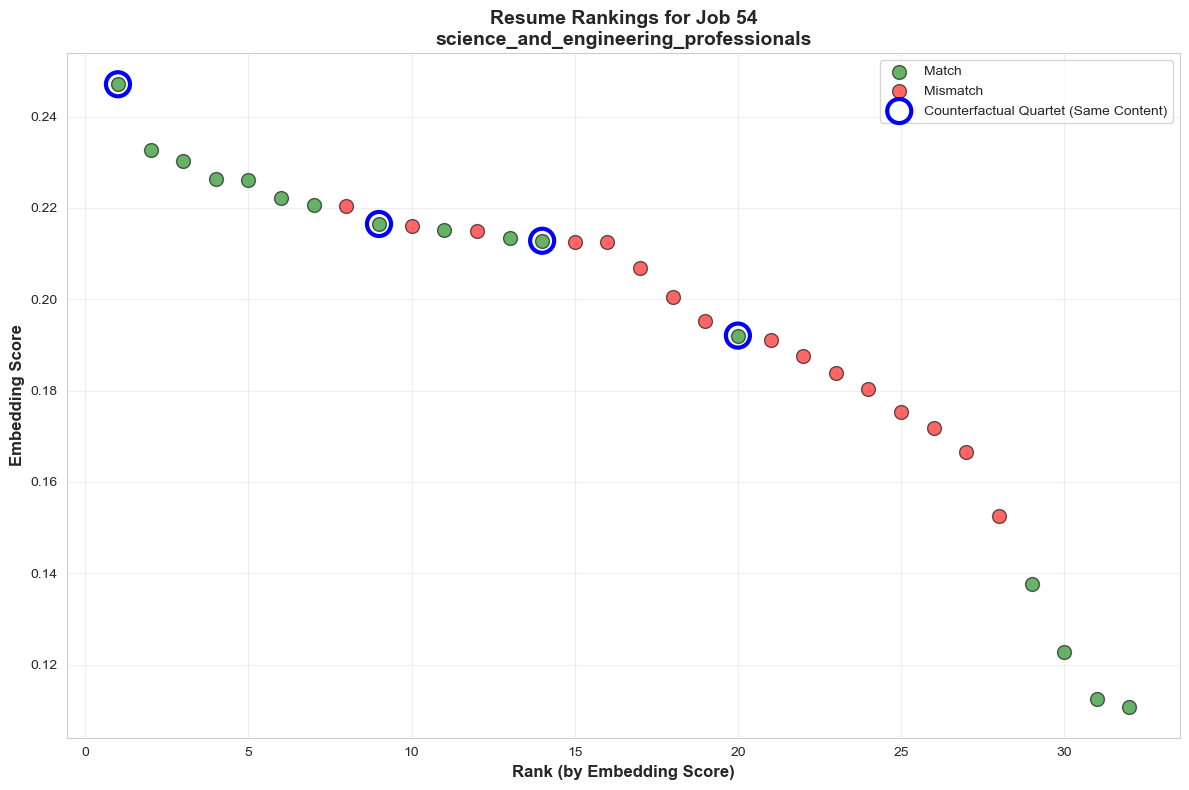

Saved figure: ../figures/phase2_example_ranking.png


In [51]:
# visualize the ranking for this job
fig, ax = plt.subplots(figsize=(12, 8))

# prepare data
job_pairs_ranked['rank'] = range(1, len(job_pairs_ranked) + 1)
job_pairs_ranked['match_color'] = job_pairs_ranked['occupation_match'].map({True: 'green', False: 'red'})

# scatter plot
for match_val, color, label in [(True, 'green', 'Match'), (False, 'red', 'Mismatch')]:
    subset = job_pairs_ranked[job_pairs_ranked['occupation_match'] == match_val]
    ax.scatter(subset['rank'], subset['score_embed'], 
               c=color, s=100, alpha=0.6, label=label, edgecolors='black')

# highlight the counterfactual quartet
quartet_ranks = job_pairs_ranked[job_pairs_ranked['base_resume_id'] == example_base_id]
ax.scatter(quartet_ranks['rank'], quartet_ranks['score_embed'],
           s=300, facecolors='none', edgecolors='blue', linewidths=3,
           label='Counterfactual Quartet (Same Content)', marker='o')

ax.set_xlabel('Rank (by Embedding Score)', fontsize=12, fontweight='bold')
ax.set_ylabel('Embedding Score', fontsize=12, fontweight='bold')
ax.set_title(f'Resume Rankings for Job {example_job_id}\n{job_pairs["job_occupation"].iloc[0]}',
             fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/phase2_example_ranking.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved figure: ../figures/phase2_example_ranking.png")

## 6. Summary

In [ ]:
# generate summary statistics
print("~" * 80)
print("PHASE 2 SUMMARY")
print("~" * 80)

# retrieval performance
tfidf_metrics = overall_metrics[overall_metrics['score_type'] == 'score_tfidf'].iloc[0]
embed_metrics = overall_metrics[overall_metrics['score_type'] == 'score_embed'].iloc[0]

print("\n1. RETRIEVAL PERFORMANCE")
print(f"   TF-IDF:     AUC={tfidf_metrics['auc']:.4f}, Gap={tfidf_metrics['gap']:.6f}, d={tfidf_metrics['cohens_d']:.4f}")
print(f"   Embeddings: AUC={embed_metrics['auc']:.4f}, Gap={embed_metrics['gap']:.6f}, d={embed_metrics['cohens_d']:.4f}")
print(f"   Improvement: +{(embed_metrics['auc'] - tfidf_metrics['auc']):.4f} AUC")

# counterfactual findings
cf_tfidf = df_counterfactual[df_counterfactual['score_type'] == 'score_tfidf']
cf_embed = df_counterfactual[df_counterfactual['score_type'] == 'score_embed']

print("\n2. COUNTERFACTUAL NAME EFFECTS")
print(f"   TF-IDF mean range:     {cf_tfidf['range'].mean():.6f}")
print(f"   Embedding mean range:  {cf_embed['range'].mean():.6f}")
print(f"   Embedding has {cf_embed['range'].mean() / cf_tfidf['range'].mean():.2f}x larger name effects")

# demographic gaps
demo_gap_tfidf = df_pairs.groupby('demographic_group')['score_tfidf'].mean().max() - \
                 df_pairs.groupby('demographic_group')['score_tfidf'].mean().min()
demo_gap_embed = df_pairs.groupby('demographic_group')['score_embed'].mean().max() - \
                 df_pairs.groupby('demographic_group')['score_embed'].mean().min()

print("\n3. DEMOGRAPHIC GROUP DIFFERENCES")
print(f"   TF-IDF max gap:    {demo_gap_tfidf:.6f}")
print(f"   Embedding max gap: {demo_gap_embed:.6f}")

# per-occupation variation
best_occ = occ_metrics.iloc[0]
worst_occ = occ_metrics.iloc[-1]

print("\n4. OCCUPATION-LEVEL VARIATION")
print(f"   Best occupation:  {best_occ['occupation']:30s} AUC={best_occ['auc']:.4f}")
print(f"   Worst occupation: {worst_occ['occupation']:30s} AUC={worst_occ['auc']:.4f}")
print(f"   Range: {best_occ['auc'] - worst_occ['auc']:.4f}")

print("\n" + "~" * 80)
print("KEY FINDINGS")
print("~" * 80)
print("""
1. Models work - Both TF-IDF and embeddings beat random (AUC > 0.5)
2. Embeddings better - Neural embeddings show stronger retrieval than TF-IDF
3. Name effects exist - Scores vary across demographic variants of identical resumes
4. Variation by occupation - Some occupations are easier to match than others

Next step: Phase 3 will quantify bias using selection rates and bootstrap confidence intervals
""")
print("~" * 80)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
PHASE 2 SUMMARY
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1. RETRIEVAL PERFORMANCE
   TF-IDF:     AUC=0.6022, Gap=0.007623, d=0.3821
   Embeddings: AUC=0.6347, Gap=0.052012, d=0.4824
   Improvement: +0.0325 AUC

2. COUNTERFACTUAL NAME EFFECTS
   TF-IDF mean range:     0.000001
   Embedding mean range:  0.031495
   Embedding has 24927.75x larger name effects

3. DEMOGRAPHIC GROUP DIFFERENCES
   TF-IDF max gap:    0.000000
   Embedding max gap: 0.003868

4. OCCUPATION-LEVEL VARIATION
   Best occupation:  teaching_professionals         AUC=0.9196
   Worst occupation: protective_services_workers    AUC=nan
   Range: nan

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KEY FINDINGS
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1. Models work - Both TF-IDF and embeddings beat random (AUC > 0.5)
2. Embeddi

## Appendix: Classifier Head Models

checking if classifier heads have been trained

In [55]:
# check if classifier models exist
from pathlib import Path

linear_head_path = DATA_DIR.parent / "models" / "linear_head.joblib"
mlp_head_path = DATA_DIR.parent / "models" / "mlp_head.pt"

if linear_head_path.exists():
    print(f"Found linear head model: {linear_head_path}")
    print("  To evaluate: Add score_linear_head column to pairs_scored_phase2.csv")
else:
    print(f"Linear head not yet trained")
    print(f"  Run: python -m src.models.train_head")

if mlp_head_path.exists():
    print(f"Found MLP head model: {mlp_head_path}")
    print("  To evaluate: Add score_mlp_head column to pairs_scored_phase2.csv")
else:
    print(f"MLP head not yet trained")
    print(f"  Run: python -m src.models.train_head")

print("\nNote: Classifier heads are evaluated in later phases when comparing learned vs retrieval models")

Found linear head model: ../data/models/linear_head.joblib
  To evaluate: Add score_linear_head column to pairs_scored_phase2.csv
Found MLP head model: ../data/models/mlp_head.pt
  To evaluate: Add score_mlp_head column to pairs_scored_phase2.csv

Note: Classifier heads are evaluated in later phases when comparing learned vs retrieval models
